In [0]:
from google.colab import drive
drive.mount('/gdrive')
import shutil, os


print('Continue?(1/0)')
continue_training=bool(int(input()))
if not continue_training:
    try:
        shutil.rmtree("/gdrive/My Drive/GAN/SIGAN/DCGAN_imgs/")
    except: pass
    os.mkdir("/gdrive/My Drive/GAN/SIGAN/DCGAN_imgs")
    try:
        shutil.rmtree("/gdrive/My Drive/GAN/SIGAN/DCGAN_checkpoints/")
    except: pass
    os.mkdir("/gdrive/My Drive/GAN/SIGAN/DCGAN_checkpoints")
    
    print('Restarted!')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Continue?(1/0)
1


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2
import random
from tensorflow.keras import layers
import time

from IPython import display
from tqdm import tqdm

path = "/gdrive/My Drive/GAN/"

In [0]:
size = (64, 64, 3)
imgs = []
files = os.listdir(path+"pokemon/")
random.shuffle(files)
file_range = 10 if len(files)-1 > 4000 else len(files)-1
for i in tqdm(range(0, file_range)):
    img = mpimg.imread(path+"pokemon/"+str(files[i]))
    img = cv2.resize(img, (size[0], size[1]), interpolation = cv2.INTER_AREA)
#     img = img / 255.0
    imgs.append(img)
    

train_images = np.array(imgs).astype('float32')
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

100%|██████████| 868/868 [00:26<00:00, 33.22it/s]


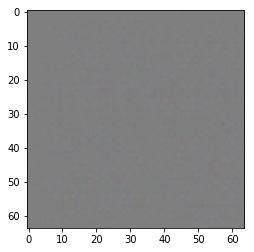

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :].numpy() * 127.5 + 127.5).astype('int32'))

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))#, activation='softmax'))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00079813]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy_regulerizer = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy_logits(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_logits(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = cross_entropy_logits(tf.ones_like(fake_output), fake_output)
    return loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = path + 'SIGAN/DCGAN_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 49

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs, start):
    for epoch in range(start, epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch) % 15 == 0:
            checkpoint.step.assign(epoch)
            checkpoint.save(file_prefix = checkpoint_prefix)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(7,7))

    for i in range(predictions.shape[0]):
        plt.subplot(7, 7, i+1)
        plt.imshow((predictions[i, :, :, :].numpy() * 127.5 + 127.5).astype('int32'))
        plt.axis('off')

    plt.savefig(path+'SIGAN/DCGAN_imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
print(checkpoint.step)
if continue_training:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print(checkpoint.step)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=7425>


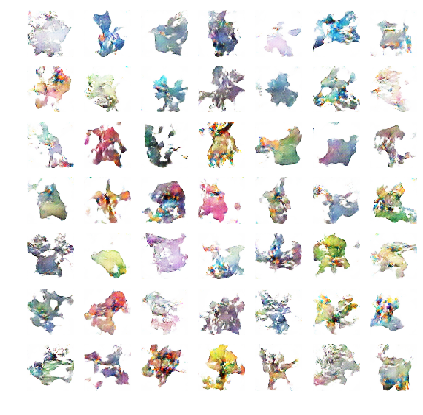

CPU times: user 9.65 s, sys: 4.53 s, total: 14.2 s
Wall time: 13.2 s


In [0]:
%%time
train(train_dataset, EPOCHS, checkpoint.step.numpy())

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

FileNotFoundError: ignored